In [2]:
%%writefile practice8.cu

#include <cuda_runtime.h> // подключает CUDA
#include <iostream> // подключает вывод
#include <vector> // подключает vector
#include <chrono> // подключает время для CPU
#include <fstream> // подключает запись CSV
#include <cstdlib> // подключает rand
#include <omp.h> // подключает OpenMP

using namespace std; // чтобы не писать std::

void cuda_ok(cudaError_t err, const char* msg) { // проверяет ошибки CUDA
    if (err != cudaSuccess) { // если есть ошибка
        cout << "CUDA error (" << msg << "): " << cudaGetErrorString(err) << endl; // выводит текст
        exit(1); // завершает программу
    }
}

__global__ void mul2_kernel(int* data, int n) { // kernel умножает элементы на 2
    int i = blockIdx.x * blockDim.x + threadIdx.x; // вычисляет индекс
    if (i < n) data[i] *= 2; // умножает элемент если индекс в пределах
}

void fill_array(int* a, int n) { // заполняет массив случайными числами
    for (int i = 0; i < n; i++) { // цикл по массиву
        a[i] = rand() % 1000; // записывает число 0..999
    }
}

void cpu_mul2_openmp(int* a, int n) { // умножает массив на CPU с OpenMP
#pragma omp parallel for // распараллеливает цикл
    for (int i = 0; i < n; i++) { // цикл по элементам
        a[i] *= 2; // умножает на 2
    }
}

bool check_equal_head(const int* a, const int* b, int n, int k) { // проверяет первые k элементов
    int m = (n < k ? n : k); // сколько реально проверять
    for (int i = 0; i < m; i++) { // цикл проверки
        if (a[i] != b[i]) return false; // если не совпало
    }
    return true; // если всё совпало
}

double ms_cpu(int* a, int n) { // замеряет время CPU обработки в мс
    auto s = chrono::high_resolution_clock::now(); // старт времени
    cpu_mul2_openmp(a, n); // умножает на CPU
    auto e = chrono::high_resolution_clock::now(); // конец времени
    return chrono::duration<double, milli>(e - s).count(); // возвращает время в мс
}

double ms_gpu_total(int* h_a, int n) { // замеряет GPU время: копия + kernel + копия
    int* d_a = nullptr; // указатель на память GPU
    cuda_ok(cudaMalloc(&d_a, n * (int)sizeof(int)), "cudaMalloc d_a"); // выделяет память на GPU

    cudaEvent_t ev1, ev2; // события CUDA для времени
    cuda_ok(cudaEventCreate(&ev1), "EventCreate start"); // создаёт start event
    cuda_ok(cudaEventCreate(&ev2), "EventCreate end"); // создаёт end event

    int threads = 256; // потоки в блоке
    int blocks = (n + threads - 1) / threads; // количество блоков

    cuda_ok(cudaEventRecord(ev1), "EventRecord start"); // старт таймера

    cuda_ok(cudaMemcpy(d_a, h_a, n * (int)sizeof(int), cudaMemcpyHostToDevice), "Memcpy H->D"); // копирует на GPU
    mul2_kernel<<<blocks, threads>>>(d_a, n); // запускает kernel
    cuda_ok(cudaGetLastError(), "kernel launch"); // проверяет запуск kernel
    cuda_ok(cudaMemcpy(h_a, d_a, n * (int)sizeof(int), cudaMemcpyDeviceToHost), "Memcpy D->H"); // копирует обратно

    cuda_ok(cudaEventRecord(ev2), "EventRecord end"); // конец таймера
    cuda_ok(cudaEventSynchronize(ev2), "EventSync end"); // ждёт завершения

    float ms = 0.0f; // переменная для времени
    cuda_ok(cudaEventElapsedTime(&ms, ev1, ev2), "ElapsedTime"); // считает время

    cuda_ok(cudaFree(d_a), "cudaFree d_a"); // освобождает GPU память
    cuda_ok(cudaEventDestroy(ev1), "EventDestroy start"); // удаляет event
    cuda_ok(cudaEventDestroy(ev2), "EventDestroy end"); // удаляет event

    return (double)ms; // возвращает время
}

double ms_hybrid(int* h_a, int n) { // гибрид: первая половина CPU, вторая GPU одновременно
    int half = n / 2; // размер первой половины
    int n2 = n - half; // размер второй половины

    int* d_b = nullptr; // память GPU для второй половины
    cuda_ok(cudaMalloc(&d_b, n2 * (int)sizeof(int)), "cudaMalloc d_b"); // выделяет память

    cudaStream_t st; // stream для асинхронных операций
    cuda_ok(cudaStreamCreate(&st), "StreamCreate"); // создаёт stream

    cudaEvent_t ev1, ev2; // события для времени
    cuda_ok(cudaEventCreate(&ev1), "EventCreate start"); // start event
    cuda_ok(cudaEventCreate(&ev2), "EventCreate end"); // end event

    int threads = 256; // потоки
    int blocks = (n2 + threads - 1) / threads; // блоки для второй половины

    cuda_ok(cudaEventRecord(ev1), "EventRecord start"); // старт таймера

    cuda_ok(cudaMemcpyAsync(d_b, h_a + half, n2 * (int)sizeof(int), cudaMemcpyHostToDevice, st), "MemcpyAsync H->D"); // копирует вторую часть
    mul2_kernel<<<blocks, threads, 0, st>>>(d_b, n2); // запускает kernel во stream
    cuda_ok(cudaGetLastError(), "kernel launch stream"); // проверяет kernel
    cuda_ok(cudaMemcpyAsync(h_a + half, d_b, n2 * (int)sizeof(int), cudaMemcpyDeviceToHost, st), "MemcpyAsync D->H"); // копирует обратно

    cpu_mul2_openmp(h_a, half); // CPU параллельно обрабатывает первую половину

    cuda_ok(cudaStreamSynchronize(st), "StreamSync"); // ждёт завершения GPU части

    cuda_ok(cudaEventRecord(ev2), "EventRecord end"); // конец таймера
    cuda_ok(cudaEventSynchronize(ev2), "EventSync end"); // ждёт

    float ms = 0.0f; // время
    cuda_ok(cudaEventElapsedTime(&ms, ev1, ev2), "ElapsedTime"); // считает время

    cuda_ok(cudaFree(d_b), "cudaFree d_b"); // освобождает GPU память
    cuda_ok(cudaStreamDestroy(st), "StreamDestroy"); // удаляет stream
    cuda_ok(cudaEventDestroy(ev1), "EventDestroy start"); // удаляет event
    cuda_ok(cudaEventDestroy(ev2), "EventDestroy end"); // удаляет event

    return (double)ms; // возвращает время
}

int main() {
    srand(123); // фиксирует random

    cout << "Practice 8: CPU(OpenMP) vs GPU(CUDA) vs Hybrid" << endl; // заголовок

    vector<int> sizes = {1000000, 10000000}; // размеры как в задании

    ofstream csv("results8.csv"); // открывает CSV файл
    csv << "n,cpu_ms,gpu_ms,hybrid_ms,gpu_ok,hybrid_ok\n"; // пишет заголовок

    for (int n : sizes) { // цикл по размерам
        int* h_base = nullptr; // общий базовый массив
        int* h_cpu = nullptr; // копия для CPU
        int* h_gpu = nullptr; // копия для GPU
        int* h_hyb = nullptr; // копия для hybrid

        cuda_ok(cudaMallocHost(&h_base, n * (int)sizeof(int)), "cudaMallocHost base"); // pinned память
        cuda_ok(cudaMallocHost(&h_cpu,  n * (int)sizeof(int)), "cudaMallocHost cpu"); // pinned память
        cuda_ok(cudaMallocHost(&h_gpu,  n * (int)sizeof(int)), "cudaMallocHost gpu"); // pinned память
        cuda_ok(cudaMallocHost(&h_hyb,  n * (int)sizeof(int)), "cudaMallocHost hyb"); // pinned память

        fill_array(h_base, n); // заполняет базовый массив

        for (int i = 0; i < n; i++) { // копирует массивы
            h_cpu[i] = h_base[i]; // копия для CPU
            h_gpu[i] = h_base[i]; // копия для GPU
            h_hyb[i] = h_base[i]; // копия для hybrid
        }

        double t_cpu = ms_cpu(h_cpu, n); // измеряет CPU время
        double t_gpu = ms_gpu_total(h_gpu, n); // измеряет GPU время
        double t_hyb = ms_hybrid(h_hyb, n); // измеряет hybrid время

        bool ok_gpu = check_equal_head(h_cpu, h_gpu, n, 1000); // проверяет первые 1000 CPU vs GPU
        bool ok_hyb = check_equal_head(h_cpu, h_hyb, n, 1000); // проверяет первые 1000 CPU vs Hybrid

        cout << "N = " << n << endl; // выводит размер
        cout << "CPU ms = " << t_cpu << endl; // выводит CPU время
        cout << "GPU ms = " << t_gpu << endl; // выводит GPU время
        cout << "Hybrid ms = " << t_hyb << endl; // выводит hybrid время
        cout << "GPU check (first 1000) = " << (ok_gpu ? "OK" : "FAIL") << endl; // выводит проверку GPU
        cout << "Hybrid check (first 1000) = " << (ok_hyb ? "OK" : "FAIL") << endl; // выводит проверку hybrid
        cout << endl; // пустая строка

        csv << n << "," << t_cpu << "," << t_gpu << "," << t_hyb << "," << (ok_gpu ? 1 : 0) << "," << (ok_hyb ? 1 : 0) << "\n"; // пишет в CSV

        cuda_ok(cudaFreeHost(h_base), "cudaFreeHost base"); // освобождает pinned память
        cuda_ok(cudaFreeHost(h_cpu), "cudaFreeHost cpu"); // освобождает pinned память
        cuda_ok(cudaFreeHost(h_gpu), "cudaFreeHost gpu"); // освобождает pinned память
        cuda_ok(cudaFreeHost(h_hyb), "cudaFreeHost hyb"); // освобождает pinned память
    }

    csv.close(); // закрывает CSV
    cout << "Saved: results8.csv" << endl; // сообщает про CSV

    return 0; // конец программы
}


Overwriting practice8.cu


In [3]:
%%bash
nvcc -O2 -Xcompiler -fopenmp -gencode arch=compute_75,code=sm_75 practice8.cu -o practice8
./practice8


Practice 8: CPU(OpenMP) vs GPU(CUDA) vs Hybrid
N = 1000000
CPU ms = 0.994504
GPU ms = 2.74688
Hybrid ms = 0.40896
GPU check (first 1000) = OK
Hybrid check (first 1000) = OK

N = 10000000
CPU ms = 4.51576
GPU ms = 6.68768
Hybrid ms = 4.92384
GPU check (first 1000) = OK
Hybrid check (first 1000) = OK

Saved: results8.csv


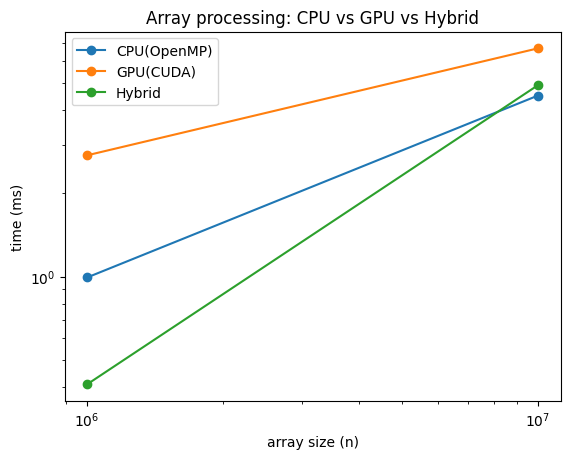

,n,cpu_ms,gpu_ms,hybrid_ms,gpu_ok,hybrid_ok
0,1000000,0.994504,2.74688,0.40896,1,1
1,10000000,4.515760,6.68768,4.92384,1,1


In [4]:
import pandas as pd # читает CSV
import matplotlib.pyplot as plt # строит графики

df = pd.read_csv("results8.csv") # загружает данные

plt.figure() # создаёт график
plt.plot(df["n"], df["cpu_ms"], marker="o") # CPU линия
plt.plot(df["n"], df["gpu_ms"], marker="o") # GPU линия
plt.plot(df["n"], df["hybrid_ms"], marker="o") # Hybrid линия
plt.xscale("log") # лог шкала X
plt.yscale("log") # лог шкала Y
plt.xlabel("array size (n)") # подпись X
plt.ylabel("time (ms)") # подпись Y
plt.title("Array processing: CPU vs GPU vs Hybrid") # заголовок
plt.legend(["CPU(OpenMP)", "GPU(CUDA)", "Hybrid"]) # легенда
plt.show() # показывает

df # выводит таблицу
